In [1]:
import os
import pandas as pd
from IPython.display import display
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
from matplotlib import pyplot as plt

from MyTransformers import *
from sklearn.model_selection import train_test_split

#%config Completer.use_jedi = False
%matplotlib inline  

In [2]:
f_data_path = "PrepedData/"
f_modele_path = 'Model/'

f_HHData = f_data_path + 'HHDataId/'

In [132]:
def AgregateDiffs(xdiff, start=0):
    return (xdiff.cumsum() + start)
n=48
def plot_series(series, y=None, y_pred=None, _n=n, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(_n, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(_n, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    #plt.axis([0, _n + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

def plot_multiple_forecasts(X, Y, Y_pred, _n=n, toAgregate=False):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    if toAgregate:
        X = AgregateDiffs(X).reshape(-1,n_steps,1)
        Y = AgregateDiffs(Y,X[:,-1]).reshape(-1,ahead,1)
        Y_pred = AgregateDiffs(Y_pred,X[:,-1]).reshape(-1,ahead,1)

    plot_series(X[0, :, 0],_n=n)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    mean = X.mean()
    plt.axis([0, n_steps + ahead, mean*-3, mean*3])
    plt.legend(fontsize=14)

def BatchWithNLen(n,pred_n,time_series, other_data=[],TVT_slit=(0.7,0.9)):
    if len(time_series) % n != 0:
        time_series = time_series[:len(time_series) - (len(time_series) % n)]

    dim = 1 if time_series.ndim == 1 else time_series.shape[-1]
    time_series = time_series.reshape(-1,n,dim)
    l = len(time_series)
    X_train = time_series[:int(l*TVT_slit[0])                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)
    X_valid = time_series[int(l*TVT_slit[0]):int(l*TVT_slit[1]), :n-pred_n, 0].reshape(-1,n-pred_n,1) 
    X_test  = time_series[int(l*TVT_slit[1]):                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)
    y_train = time_series[:int(l*TVT_slit[0])                  , -pred_n:, 0].reshape(-1,pred_n,1)
    y_valid = time_series[int(l*TVT_slit[0]):int(l*TVT_slit[1]), -pred_n:, 0].reshape(-1,pred_n,1)
    y_test  = time_series[int(l*TVT_slit[1]):                  , -pred_n:, 0].reshape(-1,pred_n,1)
    if len(other_data) > 0:
        if len(other_data) % n != 0:
           other_data = other_data[:len(other_data) - (len(other_data) % n)]

        dim = 1 if other_data.ndim == 1 else other_data.shape[-1]
        other_data = other_data.reshape(-1,n,dim)
        X_other_train = other_data[:int(l*TVT_slit[0])                  , -pred_n, :]
        X_other_valid = other_data[int(l*TVT_slit[0]):int(l*TVT_slit[1]), -pred_n, :]
        X_other_test  = other_data[int(l*TVT_slit[1]):                  , -pred_n, :]
        return (X_train, y_train, X_other_train), (X_valid, y_valid, X_other_valid) , (X_test, y_test, X_other_test)
    return (X_train, y_train), (X_valid, y_valid) , (X_test, y_test)
    
def OverlapingBatchWithNLen(n,pred_n,time_series, other_data=[],TVT_slit=(0.7,0.9)):
    if len(time_series) % n != 0:
        time_series = time_series[:len(time_series) - (len(time_series) % n)]

    dim = 1 if time_series.ndim == 1 else time_series.shape[-1]
    time_series = time_series.reshape(-1,n,dim)
    l = len(time_series)
    X_train = time_series[:int(l*TVT_slit[0])                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)
    X_valid = time_series[int(l*TVT_slit[0]):int(l*TVT_slit[1]), :n-pred_n, 0].reshape(-1,n-pred_n,1) 
    X_test  = time_series[int(l*TVT_slit[1]):                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)

    Y = np.empty((l, n-pred_n, pred_n))
    for step_ahead in range(1, pred_n + 1):
        Y[..., step_ahead - 1] = time_series[..., step_ahead:step_ahead + n - pred_n, 0]    
        
    y_train = Y[:int(l*TVT_slit[0])                  ]
    y_valid = Y[int(l*TVT_slit[0]):int(l*TVT_slit[1])]
    y_test  = Y[int(l*TVT_slit[1]):                  ]
    
    if len(other_data) > 0:
        if len(other_data) % n != 0:
           other_data = other_data[:len(other_data) - (len(other_data) % n)]

        dim = 1 if other_data.ndim == 1 else other_data.shape[-1]
        other_data = other_data.reshape(-1,n,dim)
        # X_other = np.empty((l, n-n_feature,n_feature, len(other_features)))
        # for step_ahead in range(1, pred_n + 1):
            # X_other[..., step_ahead - 1, :] = b[..., step_ahead:step_ahead + n - n_feature, 1:]
        # X_other_train = X_other[:int(l*0.7)           , ...]
        # X_other_valid = X_other[int(l*0.7):int(l*0.9) , ...]
        # X_other_test  = X_other[int(l*0.9):           , ...]

        X_other_train = other_data[:int(l*TVT_slit[0])                  , pred_n:n, :]
        X_other_valid = other_data[int(l*TVT_slit[0]):int(l*TVT_slit[1]), pred_n:n, :]
        X_other_test  = other_data[int(l*TVT_slit[1]):                  , pred_n:n, :]
        return (X_train, y_train, X_other_train), (X_valid, y_valid, X_other_valid) , (X_test, y_test, X_other_test)
    return (X_train, y_train), (X_valid, y_valid) , (X_test, y_test)
    
class MyLoader:
    def __init__(self,files,batchSize,timeSeriesLables, otherDataLabels,splitFun, sumInN = 1, asDiff = False, asSum = False, TVT_split=(0.7,0.9),
     pred_n = 10,lable="default"):
        self.batchSize = batchSize
        self.timeSeriesLables = timeSeriesLables
        self.otherDataLabels = otherDataLabels
        self.sumInN = sumInN
        self.asDiff = asDiff
        self.asSum = asSum
        self.files = files
        self.TVT_split = TVT_split
        self.pred_n = pred_n
        self.splitFun = splitFun
        self.lable = lable

    def loadDataTimeSeries(files, features, batchSize,sum_n = 1, asSum=True, asDiff=True):
        tmpArr = [[]]*len(files)
        dataOut = np.empty((0,len(features)))
        for i,file in enumerate(files):
            progres_bar(i + 1,len(files))
            data = pd.read_feather(file)
            data = data[features].values
            if asSum:
                data = data[:len(data) - (len(data) % sum_n)]
                if len(features) > 1:
                    data = data.reshape(-1,sum_n,len(features))     
                else:
                    data = data.reshape(-1,sum_n)
                data = data.sum(axis=1,keepdims=True)
            if asDiff:
                data = np.diff(data,axis=0)
                data = data[1:]

            tmpArr[i] = data[:len(data) - (len(data) % batchSize)]
        if len(files) > 0:    
            dataOut = np.row_stack(tmpArr)
        else:
            dataOut = tmpArr[0]
        return dataOut.astype('f4')

    def loadDataOther(files, features, batchSize):
        tmpArr = [[]]*len(files)
        dataOut = np.empty((0,len(features)))
        for i,file in enumerate(files):
            progres_bar(i + 1,len(files))
            data = pd.read_feather(file)
            data = data[features].values
            tmpArr[i] = data[:len(data) - (len(data) % batchSize)]
        if len(files) > 0:    
            dataOut = np.row_stack(tmpArr)
        else:
            dataOut = tmpArr[0]
        return dataOut.astype('f4')

    def load(self):
        self.timeSeries = MyLoader.loadDataTimeSeries(self.files, self.timeSeriesLables, self.batchSize, self.sumInN, self.asSum, self.asDiff)
        if self.hasOther():
            self.otherData = MyLoader.loadDataOther(self.files, self.otherDataLabels, self.batchSize)
            (self.XTrain, self.YTrain, self.XOtherTrain), (self.XValid, self.YValid, self.XOtherValid), (self.XTest, self.YTest, self.XOtherTest) = self.splitFun(self.batchSize,self.pred_n,self.timeSeries, self.otherData, self.TVT_split)
        else:
            (self.XTrain, self.YTrain), (self.XValid, self.YValid), (self.XTest, self.YTest) = self.splitFun(self.batchSize,self.pred_n,self.timeSeries, [], self.TVT_split)

    def hasOther(self):
        return True if self.otherDataLabels else False

class MyModel:
    _model = None
    _lableDefined = False
    _dataLoaded = False
    _trainingStarted = False
    def __init__(self, batchSize, loader,lable,createModel,modelArgs,modleDims,predDataFun):
        self.batchSize = batchSize
        self.loader = loader
        self._lable = lable
        self.createModel = createModel
        self.modelArgs = modelArgs
        self.modleDims = modleDims
        self.predDataFun = predDataFun

    def load(self):
        if not self._dataLoaded:
            self.loader.load() 
            self._dataLoaded = True
        
    def model(self):
        if self._model == None:
            dim = 1 if self.loader.timeSeries.ndim == 1 else self.loader.timeSeries.shape[-1]
            print(self.loader.hasOther())
            if self.loader.hasOther():
                dim = [dim, 1 if self.loader.otherData.ndim == 1 else self.loader.otherData.shape[-1]]
            self._model = self.createModel(self.batchSize,dim,self.modelArgs, self.modleDims)
        return self._model

    def lable(self):
        if not self._lableDefined:
            for i in range(len(self.modleDims)):
                self._lable += f"-{self.modleDims[i]}" 
            self._lable += '-Batch-'+ str(self.batchSize)
            self._lableDefined = True
        return self._lable

    def prepModel(self, loss='mse', optimizer='adam', learningRate=0.01):
        if optimizer == 'adam':
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        self.model().compile(loss=loss, optimizer=opt)
        self.tbCallBack = keras.callbacks.TensorBoard(log_dir=f'./Graph/{self.loader.lable}/n{self.batchSize}/{optimizer}-LeRate-{learningRate}-loss-{loss}/{self.lable()}', histogram_freq=0, write_graph=True, write_images=True)

    def train(self,epochs,loss='mse', optimizer='adam', learningRate=0.01):
        if not self._trainingStarted:
            self.load()
            self.prepModel(loss,optimizer,learningRate)
            self.history = []
            self.trainData , self.validData, self.testData = self.predDataFun(self.loader)
            self._trainingStarted = True

        self.history.append(self.model().fit(self.trainData[0], self.trainData[1], epochs=epochs,
        validation_data=self.validData,callbacks=[self.tbCallBack]))
    

    def test(self,plotsCount=5,batchStart=1,random=False):
        batchs = range(batchStart,batchStart + plotsCount)
        if random:
            batchs = np.round(np.random.rand(plotsCount) * (len(self.testData[1])-1)).astype('i4')
        for batch in batchs:
            print(batch)
            if self.loader.hasOther():
                X_new = [[]]*len(self.testData[0])
                for i,vec in enumerate(self.testData[0]):
                    X_new[i] = vec[batch:batch+1]
            else:
                X_new = self.testData[0][0][batch:batch+1]

            Y_new = self.testData[1][batch:batch+1]
            if self.loader.splitFun == OverlapingBatchWithNLen:
                Y_pred = self.model().predict(X_new)[:, -self.loader.pred_n:]
            elif self.loader.splitFun == BatchWithNLen:
                Y_pred = self.model().predict(X_new).reshape(1,self.loader.pred_n,1)
            if self.loader.hasOther():
                plot_multiple_forecasts(X_new[0], Y_new, Y_pred, toAgregate=self.loader.asDiff)
            else :
                plot_multiple_forecasts(X_new, Y_new, Y_pred, toAgregate=self.loader.asDiff)
            plt.figure()

def DrawTestPlots(to_pred,time_series,other_data=[],plotsCount=5,n=30,batchStart=10,randomBatch=True, toAgregate=True):
    batchs = range(batchStart,batchStart + plotsCount)
    if randomBatch:
        batchs = np.round(np.random.rand(plotsCount) * (len(time_series)/n)).astype('i4')
    for batch in batchs:
        X_new = time_series[batch*n               :batch*n + n - to_pred].reshape(1,n-to_pred,1)
        Y_new = time_series[batch*n + n - to_pred :batch*n + n          ].reshape(1,to_pred  ,1)
        if len(other_data) > 0:
            dim = 1 if other_data.ndim == 1 else other_data.shape[-1]
            X_other_new = other_data[batch*n              :batch*n + n - to_pred].reshape(1,n-to_pred,dim)
            Y_pred = model.predict((X_new,X_other_new))[:, -to_pred:]
        else:
            Y_pred = model.predict((X_new))[:, -to_pred:]
        plot_multiple_forecasts(X_new, Y_new, Y_pred, toAgregate=toAgregate)
        plt.figure()


### Test Data Load

In [ ]:
def loadIdsData(ids, features, _n, asDiff=True):
    tmp_arr = [[]]*len(ids)
    time_series = np.empty((0,len(features)))
    #other_series = []
    for i,id in enumerate(ids):
        progres_bar(i + 1,len(ids))
        data = pd.read_feather(f_HHData + id)
        if asDiff:
            data[features] = data[features].diff()
            data = data.iloc[1:]
        tmp_arr[i] = data[features][:len(data) - (len(data) % _n)].copy()
        #time_series = np.row_stack((time_series, data[features][:len(data) - (len(data) % _n)]))
        # other_series = np.append(other_series, data['temperature'][:len(data) - (len(data) % _n)]) 
    #series = np.column_stack((time_series,other_series))
    time_series = np.row_stack(tmp_arr)
    return time_series.astype('f4')

def loadLPGData(features, sum_n = 1, asSum=True, asDiff=True):
    data = pd.read_feather(f_data_path + "LPG-Profile-0.feather")
    data = data[features].values
    if asSum:
        data = data[:len(data) - (len(data) % sum_n)]
        data = data.reshape(-1,sum_n).sum(axis=1)
    if asDiff:
        data = np.diff(data)
        data = data[1:]
    return data

In [6]:
id = 2
data = pd.read_feather(f_HHData + f'{id}.feather')
features = ['energy']
other_features = ['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET']

In [7]:
data.columns

Index(['energy', 'temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent',
       'yearPrecent', 'pastET', 'energy_0', 'energy_1', 'energy_2',
       'energy_3'],
      dtype='object')

In [8]:
# Change energy to energy diff
start = data['energy'][0]
data[features] = data[features].diff()
data = data.iloc[1:]

# Predict 1 from RNN model that gives 1 pred 

### Tensor Convert

In [9]:

tf_data = tf.data.Dataset.from_tensor_slices(tf.cast(data[features].values, tf.float32))

In [14]:
d = tf.convert_to_tensor(data[features])

In [25]:
b = tf_data.batch(48)

### Data Convert

In [95]:
LGP = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=True,
    pred_n=1,
    lable="LPG")
LGP.load()
X_train, y_train,X_valid, y_valid ,X_test, y_test = LGP.XTrain , LGP.YTrain , LGP.XValid, LGP.YValid, LGP.XTest, LGP.YTest
# n = 48*1 # 4 dni
# b = loadDataTimeSeries([f_data_path + "LPG-Profile-0.feather"],['energy'],n,60*3,asSum=True,asDiff=False)
# print(b.shape)
#b = loadLPGData(time_series_feature,sum_n=60*3,asDiff=False)
# (X_train, y_train), (X_valid, y_valid) , (X_test, y_test) = BatchWithNLen(n,1,b)

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [97]:
Lond = MyLoader(
    files=[f_HHData + id for id in os.listdir(f_HHData)[:1]],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET'],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=False,
    asDiff=True,
    pred_n=1,
    lable="Lond")
Lond.load()
X_train, y_train,X_valid, y_valid ,X_test, y_test, X_other_train ,X_other_valid , X_other_test = Lond.XTrain , Lond.YTrain , Lond.XValid, Lond.YValid, Lond.XTest, Lond.YTest, Lond.XOtherTrain,Lond.XOtherValid,Lond.XOtherTest

# files = [f_HHData + id for id in ids]
# time_series_feature = ['energy']
# other_features = ['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET']
# n = 48*1 # 4 dni
# # b = loadIdsData(ids, time_series_feature + other_features, n)
# b = loadDataTimeSeries(files,time_series_feature,n,asSum=False,asDiff=True)
# o = loadDataOther(files,other_features,n)
# (X_train, y_train, X_other_train), (X_valid, y_valid, X_other_valid) , (X_test, y_test, X_other_test) = BatchWithNLen(n,1,b,o)

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [98]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape , X_other_train.shape, X_other_valid.shape, X_other_test.shape

((364, 47, 1),
 (364, 1, 1),
 (104, 47, 1),
 (104, 1, 1),
 (52, 47, 1),
 (52, 1, 1),
 (364, 6),
 (104, 6),
 (52, 6))

### Base line

In [153]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

1.1929538035143379

### Models

In [118]:
LPG = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=True,
    pred_n=1,
    lable="LPG")

LPG5 = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=True,
    pred_n=5,
    lable="LPG")

Lond = MyLoader(
    files=[f_HHData + id for id in os.listdir(f_HHData)[:1]],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET'],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=False,
    asDiff=True,
    pred_n=1,
    lable="Lond")

Lond5 = MyLoader(
    files=[f_HHData + id for id in os.listdir(f_HHData)[:1]],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET'],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=False,
    asDiff=True,
    pred_n=5,
    lable="Lond")


In [128]:
def createFlattenModel(batchSize,timeSDim,args,dims): #batchSize, Dims
          return keras.models.Sequential([
            keras.layers.Flatten(input_shape=[batchSize-dims[-1], timeSDim]),
            keras.layers.Dense(dims[-1])])
def predDataDefault(l):
    return ([l.XTrain],l.YTrain),([l.XValid], l.YValid),([l.XTest],l.YTest)
        
def predDataWithOther(l):
    return ([l.XTrain,l.XOtherTrain],l.YTrain),([l.XValid,l.XOtherValid], l.YValid),([l.XTest,l.XOtherTest],l.YTest)
        
Flatten = MyModel(
    batchSize=48,
    loader=LPG,
    lable="Flatten",
    createModel=createFlattenModel,
    modelArgs=[],
    modleDims=[48,1],
    predDataFun=predDataDefault
)

Flatten5 = MyModel(
    batchSize=48,
    loader=LPG5,
    lable="Flatten",
    createModel=createFlattenModel,
    modelArgs=[],
    modleDims=[48,5],
    predDataFun=predDataDefault
)
    

def createSimpleRNN (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.SimpleRNN(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.SimpleRNN(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.SimpleRNN(dims[-1]))
    return m

SimpleRNN = MyModel(
    batchSize=48,
    loader=LPG,
    lable="SimpleRNN",
    createModel=createSimpleRNN,
    modelArgs=[],
    modleDims=[20,20,1],
    predDataFun=predDataDefault
)

SimpleRNN5 = MyModel(
    batchSize=48,
    loader=LPG5,
    lable="SimpleRNN",
    createModel=createSimpleRNN,
    modelArgs=[],
    modleDims=[20,20,5],
    predDataFun=predDataDefault
)

def createSimpleRNNWithOtherData(batchSize, dataDim, args, dims):
    input_A = keras.layers.Input(shape=[None, dataDim[0]], name="Time-series")
    input_B = keras.layers.Input(shape=[dataDim[1]], name="other")
    hidden1 = keras.layers.SimpleRNN(dims[0], return_sequences=True)(input_A)
    for i in range(1,len(dims)-2):
        hidden1 = keras.layers.SimpleRNN(dims[i], return_sequences=True)(hidden1)
    hidden2 = keras.layers.SimpleRNN(dims[-2], return_sequences=False)(hidden1)
    hidden3 = keras.layers.Dense(dims[-1])(hidden2)
    concat = keras.layers.concatenate([input_B, hidden3])
    output = keras.layers.Dense(dims[-1], name="output")(concat)
    return keras.Model(inputs=[input_A, input_B], outputs=[output])

SimpleRNNWithOtherData = MyModel(
    batchSize=48,
    loader=Lond,
    lable="SimpleRNNWithOther",
    createModel=createSimpleRNNWithOtherData,
    modelArgs=[],
    modleDims=[20,20,1],
    predDataFun=predDataWithOther
)

SimpleRNNWithOtherData5 = MyModel(
    batchSize=48,
    loader=Lond5,
    lable="SimpleRNNWithOther",
    createModel=createSimpleRNNWithOtherData,
    modelArgs=[],
    modleDims=[20,20,5],
    predDataFun=predDataWithOther
)

In [129]:
#SimpleRNN.train(2)
#SimpleRNNWithOtherData.train(2)
SimpleRNNWithOtherData5.train(2)

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
True
Epoch 1/2
12/12 [==============================] - 6s 357ms/step - loss: 24.9798 - val_loss: 3.5410
Epoch 2/2
12/12 [==============================] - 2s 202ms/step - loss: 4.1896 - val_loss: 3.1551


In [80]:
def test(self,plotsCount=5,batchStart=1,random=True):
        batchs = range(batchStart,batchStart + plotsCount)
        if random:
            batchs = np.round(np.random.rand(plotsCount) * (len(self.testData[1])/self.batchSize)).astype('i4')
        for batch in batchs:

            if self.loader.hasOther():
                X_new = [[]]*len(self.testData[0])
                for i,vec in enumerate(self.testData[0]):
                    X_new[i] = vec[batch:batch+1]
            else:
                X_new = self.testData[0][0][batch:batch+1]

            Y_new = self.testData[1][batch:batch+1]
            if self.loader.splitFun == OverlapingBatchWithNLen:
                Y_pred = self.model().predict(X_new)[:, -self.loader.pred_n:]
            elif self.loader.splitFun == BatchWithNLen:
                Y_pred = self.model().predict(X_new).reshape(1,self.loader.pred_n,1)
            if self.loader.hasOther():
                plot_multiple_forecasts(X_new[0], Y_new, Y_pred, toAgregate=self.loader.asDiff)
            else :
                plot_multiple_forecasts(X_new, Y_new, Y_pred, toAgregate=self.loader.asDiff)
            plt.figure()

(1, 47, 1)
(1, 47, 1)
(1, 47, 1)
(1, 47, 1)
(1, 47, 1)


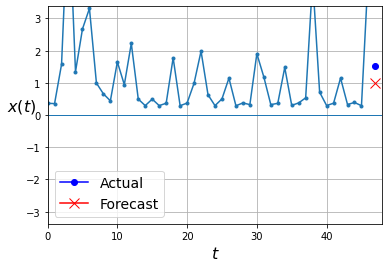

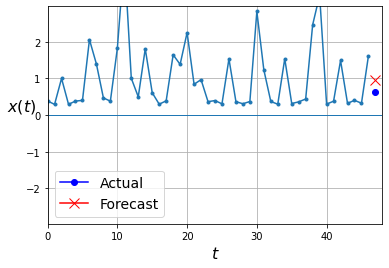

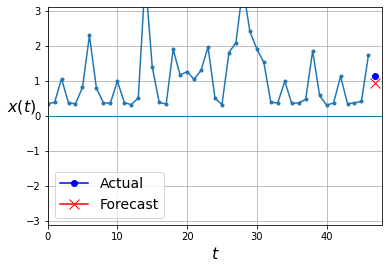

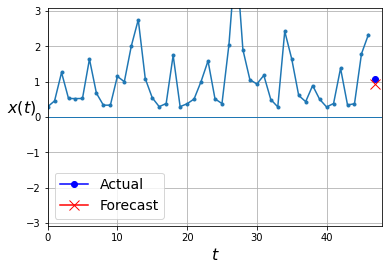

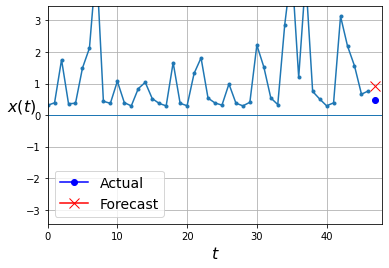

<Figure size 432x288 with 0 Axes>

In [77]:
test(SimpleRNN,random=False)

In [114]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n-1, 2]),
    keras.layers.Dense(1)
])

In [67]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 2]),
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.SimpleRNN(1)
])


In [89]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(1)
])

In [32]:
input_A = keras.layers.Input(shape=[None, 1], name="Time-series")
input_B = keras.layers.Input(shape=[6], name="other")
hidden1 = keras.layers.SimpleRNN(20, return_sequences=True)(input_A)
hidden2 = keras.layers.SimpleRNN(20, return_sequences=False)(hidden1)
hidden3 = keras.layers.Dense(1)(hidden2)
concat = keras.layers.concatenate([input_B, hidden3])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

### Define callback and Train

In [90]:
model.compile(loss="mse", optimizer="adam")
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph/LPG/SimRNN20-20-1-3h-v2', histogram_freq=0, write_graph=True, write_images=True)

In [91]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),callbacks=[tbCallBack])

Epoch 1/10
3/3 [==============================] - 4s 1s/step - loss: 1.8788 - val_loss: 1.4199
Epoch 2/10
3/3 [==============================] - 1s 402ms/step - loss: 1.0082 - val_loss: 0.7806
Epoch 3/10
3/3 [==============================] - 1s 285ms/step - loss: 0.5245 - val_loss: 0.4112
Epoch 4/10
3/3 [==============================] - 1s 258ms/step - loss: 0.2623 - val_loss: 0.2401
Epoch 5/10
3/3 [==============================] - 1s 248ms/step - loss: 0.2090 - val_loss: 0.1985
Epoch 6/10
3/3 [==============================] - 1s 244ms/step - loss: 0.2163 - val_loss: 0.2022
Epoch 7/10
3/3 [==============================] - 1s 257ms/step - loss: 0.2364 - val_loss: 0.1969
Epoch 8/10
3/3 [==============================] - 1s 241ms/step - loss: 0.2218 - val_loss: 0.1804
Epoch 9/10
3/3 [==============================] - 1s 229ms/step - loss: 0.1878 - val_loss: 0.1672
Epoch 10/10
3/3 [==============================] - 1s 257ms/step - loss: 0.1555 - val_loss: 0.1685


In [36]:
history = model.fit((X_train, X_other_train), y_train, epochs=100, validation_data=((X_valid,X_other_valid), y_valid),callbacks=[tbCallBack])

Epoch 1/100
12/12 [==============================] - 3s 273ms/step - loss: 0.2683 - val_loss: 0.4506
Epoch 2/100
12/12 [==============================] - 3s 225ms/step - loss: 0.2571 - val_loss: 0.4474
Epoch 3/100
12/12 [==============================] - 3s 252ms/step - loss: 0.2446 - val_loss: 0.4622
Epoch 4/100
12/12 [==============================] - 3s 212ms/step - loss: 0.2426 - val_loss: 0.4155
Epoch 5/100
12/12 [==============================] - 2s 184ms/step - loss: 0.2345 - val_loss: 0.4360
Epoch 6/100
12/12 [==============================] - 2s 188ms/step - loss: 0.2191 - val_loss: 0.4496
Epoch 7/100
12/12 [==============================] - 2s 182ms/step - loss: 0.2142 - val_loss: 0.4102
Epoch 8/100
12/12 [==============================] - 2s 183ms/step - loss: 0.2044 - val_loss: 0.4397
Epoch 9/100
12/12 [==============================] - 2s 181ms/step - loss: 0.1898 - val_loss: 0.4442
Epoch 10/100
12/12 [==============================] - 2s 188ms/step - loss: 0.1819 - val_lo

In [38]:
model.evaluate((X_valid,X_other_valid), y_valid)

4/4 [==============================] - 0s 45ms/step - loss: 0.4441


0.4441050887107849

### Plots and Tests

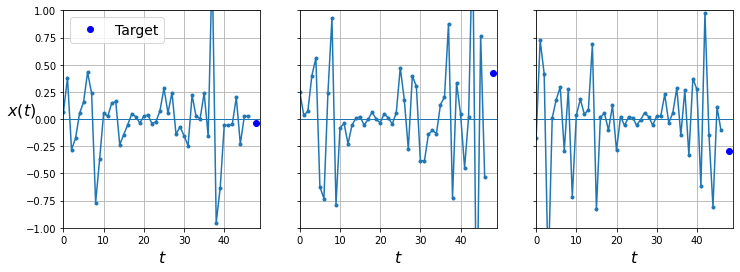

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],y_label=("$x(t)$" if col==0 else None),legend=(col == 0))
plt.show()

In [161]:
y_pred = model.predict((X_valid,X_other_valid))
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

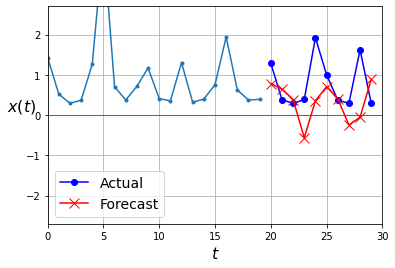

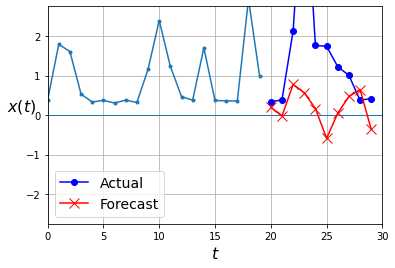

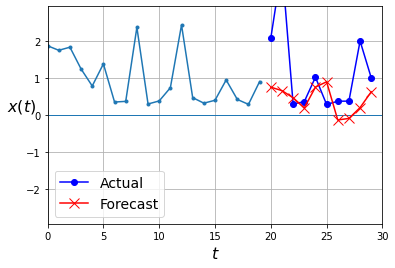

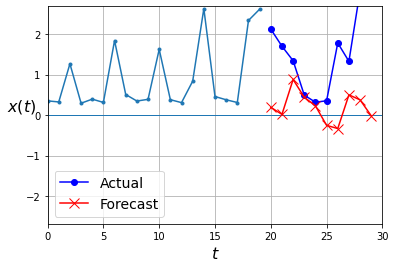

<Figure size 432x288 with 0 Axes>

In [19]:
n = 30; to_pred = 10
for batch in range(1,5):
    X_new = b[batch*n                :batch*n + n - to_pred].reshape(1,n-to_pred,1)
    Y_new = b[batch*n + n - to_pred  :batch*n + n          ].reshape(1,to_pred  ,1)

    Y_pred = np.empty(to_pred)
    for step_ahead in range(to_pred):
        y_pred_one = model.predict((X_new[:, step_ahead:]))[:, np.newaxis, :]
        Y_pred[step_ahead] = y_pred_one
        X_new = np.concatenate((X_new, y_pred_one), axis=1)

    Y_pred = Y_pred.reshape(1,to_pred,1)
    plot_multiple_forecasts(X_new[:,:n-to_pred], Y_new, Y_pred, toAgregate=False)
    plt.figure()

In [117]:
batch = 9
X_new, Y_new = b[batch, :n - 10,0].reshape(1,n-10,1), b[batch, n - 10:,0].reshape(1,10,1)
X_other_new = b[batch, n - 10:,1:]

Y_pred = []
for step_ahead in range(10):
    y_pred_one = model.predict((X_new[:, step_ahead:],X_other_new[step_ahead].reshape(1,6)))[:, np.newaxis, :]
    Y_pred = np.append(Y_pred, y_pred_one)
    X_new = np.concatenate((X_new, y_pred_one), axis=1)

Y_pred = Y_pred.reshape(1,10,1)
# plot_multiple_forecasts(X_new, Y_new, Y_pred)
plot_multiple_forecasts(X_new[:n-10], Y_new, Y_pred, toAgregate=True)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [59]:
np.mean(keras.metrics.mean_squared_error(Y_new, Y_pred))

0.10682484

# RNN Modle 10 pred at once 

## Atempt 1

### Data Convert

In [41]:
n = 48*1 # 4 dni
n_feature = 10
time_series_feature = ['energy']
b = loadLPGData(time_series_feature,sum_n=60*3,asDiff=False)
(X_train, Y_train), (X_valid, Y_valid) , (X_test, Y_test) = BatchWithNLen(n,n_feature,b)

In [37]:
#TESt czy dane są fanktycznie w 48 okresie 
ids = os.listdir(f_HHData)[:1]
time_series_feature = ['energy']
other_features = ['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET']
n = 48*1 # 4 dni
n_feature = 10

b = loadIdsData(ids, time_series_feature + other_features, n)
#X_train, Y_train, X_other_train), (X_valid, Y_valid, X_other_valid) , (X_test, Y_test, X_other_test) = BatchWithNLen(n,n_feature,b[:,0],b[:,1:])
(X_train, Y_train), (X_valid, Y_valid) , (X_test, Y_test) = BatchWithNLen(n,n_feature,b[:,0])

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [40]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((84, 38, 1), (84, 10, 1), (24, 38, 1), (24, 10, 1), (13, 38, 1), (13, 10, 1))

### Models

In [65]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n - n_feature, 1]),
    keras.layers.Dense(n_feature)
])

In [42]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(n_feature)
])


### Define callback and Train

In [43]:
model.compile(loss="mse", optimizer="adam")
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph/LPG/SimRNN20-20-10-3h', histogram_freq=0, write_graph=True, write_images=True)

In [44]:
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid),callbacks=[tbCallBack])

Epoch 1/20
3/3 [==============================] - 4s 973ms/step - loss: 2.4087 - val_loss: 2.2592
Epoch 2/20
3/3 [==============================] - 1s 207ms/step - loss: 1.9197 - val_loss: 1.8110
Epoch 3/20
3/3 [==============================] - 1s 199ms/step - loss: 1.5453 - val_loss: 1.4958
Epoch 4/20
3/3 [==============================] - 1s 192ms/step - loss: 1.3014 - val_loss: 1.3045
Epoch 5/20
3/3 [==============================] - 1s 190ms/step - loss: 1.1373 - val_loss: 1.1716
Epoch 6/20
3/3 [==============================] - 1s 183ms/step - loss: 1.0209 - val_loss: 1.0637
Epoch 7/20
3/3 [==============================] - 1s 183ms/step - loss: 0.9248 - val_loss: 0.9730
Epoch 8/20
3/3 [==============================] - 1s 182ms/step - loss: 0.8460 - val_loss: 0.9001
Epoch 9/20
3/3 [==============================] - 1s 195ms/step - loss: 0.7838 - val_loss: 0.8443
Epoch 10/20
3/3 [==============================] - 1s 193ms/step - loss: 0.7379 - val_loss: 0.8020
Epoch 11/20
3/3 [==

In [73]:
model.evaluate(X_valid, Y_valid)

4/4 [==============================] - 0s 40ms/step - loss: 0.0502


0.05022783577442169

### Plots

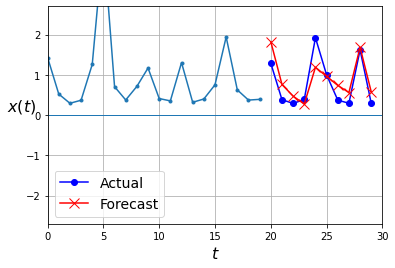

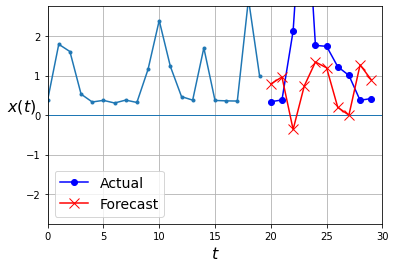

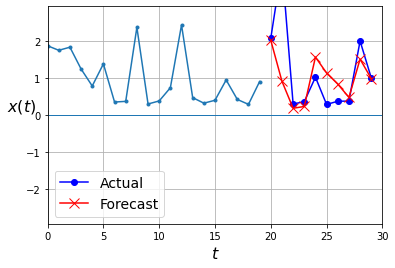

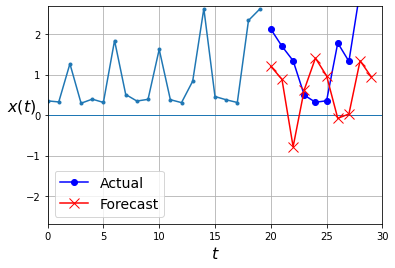

<Figure size 432x288 with 0 Axes>

In [46]:
n = 30; to_pred = 10
for batch in range(1,5):
    X_new = b[batch*n                  :batch*n + n - n_feature].reshape(1,n-n_feature,1)
    Y_new = b[batch*n + n - n_feature  :batch*n + n            ].reshape(1,n_feature  ,1)

    Y_pred = model.predict(X_new)[..., np.newaxis]
    plot_multiple_forecasts(X_new, Y_new, Y_pred, toAgregate=False)
    plt.figure()

added 0
added [[0.2589999]]
added [[0.2589999]]


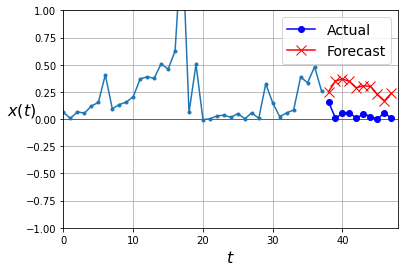

In [99]:
batch = 0
X_new, Y_new = b[batch, :n - n_feature, :].reshape(1,n-n_feature,1), b[batch, -n_feature:, :].reshape(1,n_feature,1)
Y_pred = model.predict(X_new)[..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred, toAgregate=True)
plt.show()

## Predict 10 attepmt 2

### Data convert

In [71]:
ids = os.listdir(f_HHData)[:10]
time_series_feature = ['energy']
other_features = ['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET']
n_feature = 10
n = 48*2 # 4 dni

b = loadIdsData(ids, time_series_feature + other_features, n)
(X_train, Y_train, X_other_train), (X_valid, Y_valid, X_other_valid) , (X_test, Y_test, X_other_test) = OverlapingBatchWithNLen(n,n_feature,b[:,0],b[:,1:])
#(X_train, Y_train), (X_valid, Y_valid) , (X_test, Y_test) = OverlapingBatchWithNLen(n,n_feature,b[:,0])

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [86]:
n = 48*1 
n_feature = 10
time_series_feature = ['energy']
b = loadLPGData(time_series_feature,sum_n=60*3,asDiff=False)
(X_train, Y_train), (X_valid, Y_valid) , (X_test, Y_test) = OverlapingBatchWithNLen(n,n_feature,b)

In [42]:

X_train.shape, Y_train.shape, X_other_train.shape, X_valid.shape, Y_valid.shape, X_other_valid.shape, X_test.shape, Y_test.shape ,X_other_test.shape

((2314, 86, 1),
 (2314, 86, 10),
 (23214, 86, 6),
 (662, 86, 1),
 (662, 86, 10),
 (6632, 86, 6),
 (331, 86, 1),
 (331, 86, 10),
 (3317, 86, 6))

### Modles

In [115]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_feature))
])


In [128]:
#BAtch normalization
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(n_feature))
])

In [29]:
#LSTM
model = keras.models.Sequential([
    keras.layers.LSTM(60, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_feature))
])

In [139]:
#GRU
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_feature))
])

In [47]:
# Conv 4x2 and GRU
k_size = 4; stride = 2
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=k_size, strides=stride, padding="valid",input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_feature))
])

In [44]:
#Wave Net
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

In [67]:
# LSTM Dropout and Nornalization
model = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(n_feature))
])

In [72]:
input_A = keras.layers.Input(shape=[None, 1], name="Time-series")
input_B = keras.layers.Input(shape=[None,6], name="other")
hidden1 = keras.layers.LSTM(86, return_sequences=True)(input_A)
norm1   = keras.layers.BatchNormalization()(hidden1)
drop1   = keras.layers.Dropout(rate=0.2)(norm1)
hidden2 = keras.layers.LSTM(20, return_sequences=True)(drop1)
norm2   = keras.layers.BatchNormalization()(hidden2)
drop2   = keras.layers.Dropout(rate=0.2)(norm2)
hidden3 = keras.layers.TimeDistributed(keras.layers.Dense(n_feature))(drop2)
hidden4 = keras.layers.TimeDistributed(keras.layers.Dense(n_feature))(input_B)
concat  = keras.layers.concatenate([hidden4, hidden3],axis=2)
norm4   = keras.layers.BatchNormalization()(concat)
drop4   = keras.layers.Dropout(rate=0.2)(norm4)
output  = keras.layers.Dense(1, name="output")(drop4)

model = keras.Model(inputs=[input_A, input_B], outputs=[output])
#model = keras.Model(inputs=[input_A], outputs=[hidden3])

### Define callback and Train

In [73]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph/LPG/EnDiffLSTM80-norma-drop0.2-20-1', histogram_freq=0, write_graph=True, write_images=True)

In [74]:
history = model.fit((X_train,X_other_train), Y_train, epochs=10, validation_data=((X_valid,X_other_valid), Y_valid),callbacks=[tbCallBack])

Epoch 1/10
73/73 [==============================] - 14s 106ms/step - loss: 0.4263 - last_time_step_mse: 0.3924 - val_loss: 0.0247 - val_last_time_step_mse: 0.0263
Epoch 2/10
73/73 [==============================] - 4s 57ms/step - loss: 0.0929 - last_time_step_mse: 0.0949 - val_loss: 0.0120 - val_last_time_step_mse: 0.0130
Epoch 3/10
73/73 [==============================] - 4s 51ms/step - loss: 0.0635 - last_time_step_mse: 0.0684 - val_loss: 0.0097 - val_last_time_step_mse: 0.0106
Epoch 4/10
73/73 [==============================] - 4s 48ms/step - loss: 0.0558 - last_time_step_mse: 0.0612 - val_loss: 0.0094 - val_last_time_step_mse: 0.0103
Epoch 5/10
73/73 [==============================] - 4s 49ms/step - loss: 0.0538 - last_time_step_mse: 0.0593 - val_loss: 0.0094 - val_last_time_step_mse: 0.0102
Epoch 6/10
73/73 [==============================] - 3s 48ms/step - loss: 0.0532 - last_time_step_mse: 0.0586 - val_loss: 0.0094 - val_last_time_step_mse: 0.0102
Epoch 7/10
73/73 [==============

In [69]:
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid),callbacks=[tbCallBack])

Epoch 1/5
73/73 [==============================] - 11s 92ms/step - loss: 0.2182 - last_time_step_mse: 0.1687 - val_loss: 0.0097 - val_last_time_step_mse: 0.0107
Epoch 2/5
73/73 [==============================] - 4s 49ms/step - loss: 0.0638 - last_time_step_mse: 0.0639 - val_loss: 0.0094 - val_last_time_step_mse: 0.0103
Epoch 3/5
73/73 [==============================] - 3s 44ms/step - loss: 0.0543 - last_time_step_mse: 0.0590 - val_loss: 0.0094 - val_last_time_step_mse: 0.0103
Epoch 4/5
73/73 [==============================] - 3s 43ms/step - loss: 0.0527 - last_time_step_mse: 0.0580 - val_loss: 0.0094 - val_last_time_step_mse: 0.0103
Epoch 5/5
73/73 [==============================] - 3s 45ms/step - loss: 0.0523 - last_time_step_mse: 0.0579 - val_loss: 0.0094 - val_last_time_step_mse: 0.0103


In [49]:
history = model.fit(X_train, Y_train[:,(k_size-1)::stride], epochs=20, validation_data=(X_valid, Y_valid[:,(k_size-1)::stride]),callbacks=[tbCallBack])

Epoch 1/20
288/288 [==============================] - 37s 104ms/step - loss: 0.0368 - last_time_step_mse: 0.0371 - val_loss: 0.0519 - val_last_time_step_mse: 0.0509
Epoch 2/20
288/288 [==============================] - 27s 92ms/step - loss: 0.0367 - last_time_step_mse: 0.0370 - val_loss: 0.0517 - val_last_time_step_mse: 0.0506
Epoch 3/20
288/288 [==============================] - 26s 89ms/step - loss: 0.0366 - last_time_step_mse: 0.0369 - val_loss: 0.0517 - val_last_time_step_mse: 0.0506
Epoch 4/20
288/288 [==============================] - 29s 100ms/step - loss: 0.0366 - last_time_step_mse: 0.0369 - val_loss: 0.0516 - val_last_time_step_mse: 0.0507
Epoch 5/20
288/288 [==============================] - 26s 92ms/step - loss: 0.0366 - last_time_step_mse: 0.0369 - val_loss: 0.0518 - val_last_time_step_mse: 0.0507
Epoch 6/20
288/288 [==============================] - 26s 91ms/step - loss: 0.0366 - last_time_step_mse: 0.0368 - val_loss: 0.0517 - val_last_time_step_mse: 0.0506
Epoch 7/20
288

In [123]:
# model.evaluate(X_valid, Y_valid)
model.evaluate(X_valid, Y_valid[:,(k_size-1)::stride])

4/4 [==============================] - 0s 22ms/step - loss: 0.0538 - last_time_step_mse: 0.0683


[0.053797122091054916, 0.06834839284420013]

### Plots

In [224]:
batch = 10

X_new, Y_new = b[batch, -n:-n_feature, 0].reshape(1,n-n_feature,1), b[batch, -n_feature:, 0].reshape(1,n_feature,1)
X_other_new = b[batch, -n:-n_feature, 1:].reshape(1,n-n_feature,len(other_features))
Y_pred = model.predict((X_new,X_other_new))[:, -n_feature:]

In [211]:
batch = 5

X_new, Y_new = b[batch, -n:-n_feature, 0].reshape(1,n-n_feature,1), b[batch, -n_feature:, 0].reshape(1,n_feature,1)
Y_pred = model.predict((X_new))[:, -n_feature:]

ValueError: in user code:

    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\input_spec.py:202 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_20 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 86, 1) dtype=float32>]


In [82]:
def DrawTestPlots(to_pred,time_series,other_data=[],plotsCount=5,n=30,batchStart=10,randomBatch=True, toAgregate=True):
    batchs = range(batchStart,batchStart + plotsCount)
    if randomBatch:
        batchs = np.round(np.random.rand(plotsCount) * (len(time_series)/n)).astype('i4')
    for batch in batchs:
        X_new = time_series[batch*n               :batch*n + n - to_pred].reshape(1,n-to_pred,1)
        Y_new = time_series[batch*n + n - to_pred :batch*n + n          ].reshape(1,to_pred  ,1)
        if len(other_data) > 0:
            dim = 1 if other_data.ndim == 1 else other_data.shape[-1]
            X_other_new = other_data[batch*n              :batch*n + n - to_pred].reshape(1,n-to_pred,dim)
            Y_pred = model.predict((X_new,X_other_new))[:, -to_pred:]
        else:
            Y_pred = model.predict((X_new))[:, -to_pred:]
        plot_multiple_forecasts(X_new, Y_new, Y_pred, toAgregate=toAgregate)
        plt.figure()

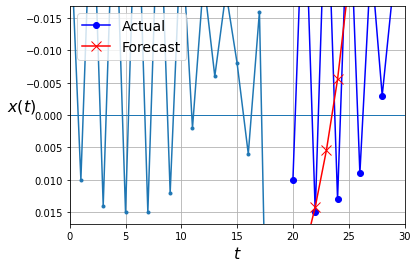

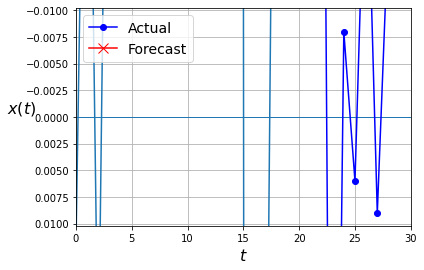

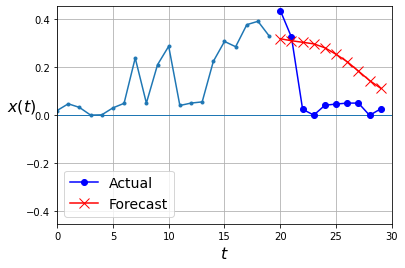

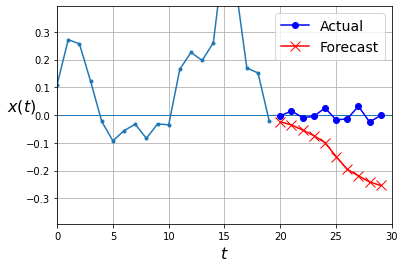

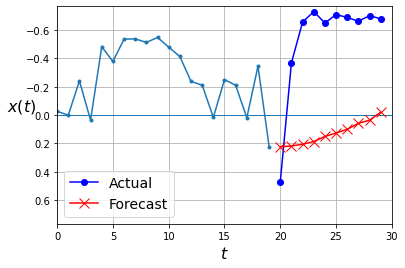

<Figure size 432x288 with 0 Axes>

In [84]:
DrawTestPlots(n_feature,b[:,0],b[:,1:],toAgregate=True)

In [59]:
n = 30; to_pred = 10;batchStart = 10
for batch in range(batchStart,batchStart + 5):
    X_new = b[batch*n                  :batch*n + n - n_feature,0].reshape(1,n-n_feature,1)
    Y_new = b[batch*n + n - n_feature  :batch*n + n            ,0].reshape(1,n_feature  ,1)

    Y_pred = model.predict((X_new))[:, -n_feature:]
    plot_multiple_forecasts(X_new, Y_new, Y_pred, toAgregate=True)
    plt.figure()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [154]:
X_new.shape, Y_new.shape, Y_pred.shape

((1, 38, 1), (1, 10, 1), (1, 10, 10))

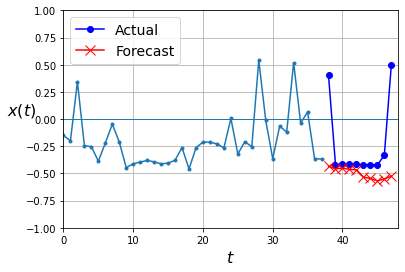

In [225]:
plot_multiple_forecasts(X_new, Y_new, Y_pred,toAgregate=True)
plt.show()

In [99]:

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)